In [1]:
# !pip install venn

In [2]:
import os

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

warnings.filterwarnings("ignore")
# warnings.filterwarnings(action='once')

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline
# plots
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    plot_confusion_matrix,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow import keras
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential

# keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook, tqdm

# from venn import venn

In [3]:
PATH = "/app/_data/"
BATCH_SIZE = 64
SEED = 42

In [4]:
labels = pd.read_csv(PATH + "train.csv")

In [5]:
sample_submission = pd.read_csv(PATH + "sample_submission.csv")

In [6]:
labels.head()
labels.info()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18632 entries, 0 to 18631
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   18632 non-null  object
 1   labels  18632 non-null  object
dtypes: object(2)
memory usage: 291.2+ KB


In [7]:
labels["labels"].value_counts(normalize=True)

scab                               0.259017
healthy                            0.248175
frog_eye_leaf_spot                 0.170728
rust                               0.099828
complex                            0.085981
powdery_mildew                     0.063547
scab frog_eye_leaf_spot            0.036818
scab frog_eye_leaf_spot complex    0.010734
frog_eye_leaf_spot complex         0.008856
rust frog_eye_leaf_spot            0.006441
rust complex                       0.005206
powdery_mildew complex             0.004669
Name: labels, dtype: float64

In [8]:
labels = labels.join(labels["labels"].str.get_dummies(sep=" "))

In [9]:
labels.head()

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,healthy,0,0,1,0,0,0
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,1,1,0,0,0,1
2,80070f7fb5e2ccaa.jpg,scab,0,0,0,0,0,1
3,80077517781fb94f.jpg,scab,0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,complex,1,0,0,0,0,0


In [10]:
# def resize_im(
#     image_name, new_folder_name="small_nearest", size=(224, 224), resample=Image.NEAREST
# ):
#     image = Image.open(PATH + "train_images/" + image_name)
#     image = image.resize(size, resample=resample)
#     if not os.path.isdir(PATH + "train_images/" + new_folder_name + "/"):
#         os.mkdir(PATH + "train_images/" + new_folder_name + "/")
#     image.save(PATH + "train_images/" + new_folder_name + "/" + image_name)


# labels['image'].apply(resize_im)

In [11]:
# labels["multi_label"] = labels["labels"].astype("category").cat.codes
# dict_weights = (
#     1
#     / labels["multi_label"].value_counts()
#     / np.sum(1 / labels["multi_label"].value_counts())
# ).to_dict()
# def weight_fill(x):
#     return dict_weights[x]
# labels["weights"] = labels["multi_label"].apply(weight_fill)

In [12]:
feature_columns = labels.columns[2:].tolist()

In [13]:
labels.sample()
feature_columns

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
13332,ddca2303c383d9b9.jpg,powdery_mildew,0,0,0,1,0,0


['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [14]:
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0 / 255,
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=45,
    width_shift_range=0.25,
    height_shift_range=0.25,
    brightness_range=(0.5, 1.5),
    shear_range=45,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
)
train = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=PATH + "train_images/small_nearest/",
    x_col="image",
    y_col=feature_columns,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="training",
    seed=SEED,
)

Found 14906 validated image filenames.


In [15]:
valid_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0 / 255,
    #     samplewise_center=True,
    #     samplewise_std_normalization=True,
    #     rotation_range=45,
    #     width_shift_range=0.25,
    #     height_shift_range=0.25,
    #     brightness_range=(0.5, 1.5),
    #     shear_range=45,
    #     zoom_range=0.25,
    #     horizontal_flip=True,
    #     vertical_flip=True,
)
valid = valid_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=PATH + "train_images/small_nearest/",
    x_col="image",
    y_col=feature_columns,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="validation",
    seed=SEED,
    classes=feature_columns,
)

Found 3726 validated image filenames.


In [16]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH + "test_images/",
    x_col="image",
    y_col=None,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode=None,
    seed=SEED,
    shuffle=False,
)

Found 3 validated image filenames.


In [17]:
# feat = next(test)
# plt.figure(figsize=(10, 10))
# for i in range(1, 4):
#     image = feat[i - 1]
#     #     label = target[i - 1]
#     plt.subplot(1, 3, i)
#     plt.imshow(image)
#     #     plt.xlabel(label)
#     plt.xticks([])
#     plt.yticks([])
#     plt.tight_layout()
# plt.show();

In [18]:
# valid._targets

In [19]:
# features, target = next(train)
# plt.figure(figsize=(10, 10))
# for i in range(1, 17):
#     image = features[i - 1]
#     label = target[i - 1]
#     plt.subplot(4, 4, i)
#     plt.imshow(image)
#     plt.xlabel(label)
#     plt.xticks([])
#     plt.yticks([])
#     plt.tight_layout()
# plt.show();

In [20]:
def plot_curves(model, loss=False):
    df = pd.DataFrame(model.history)
    if loss:
        plt.figure(figsize=(12, 6))
        plt.title("loss")
        plt.plot(df.iloc[:, 0], label="loss")
        plt.plot(df.iloc[:, 5], label="val_loss")
        plt.legend()
        plt.show()
    else:
        plt.figure(figsize=(12, 20))
        plt.subplot(4, 1, 1)
        plt.title("accuracy")
        plt.plot(df.iloc[:, 1], label="accuracy")
        plt.plot(df.iloc[:, 6], label="val_accuracy")
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.title("recall")
        plt.plot(df.iloc[:, 2], label="recall")
        plt.plot(df.iloc[:, 7], label="val_recall")
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.title("precision")
        plt.plot(df.iloc[:, 3], label="precision")
        plt.plot(df.iloc[:, 8], label="val_precision")
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.title("f1")
        plt.plot(df.iloc[:, 4], label="f1")
        plt.plot(df.iloc[:, 9], label="val_f1")
        plt.legend()
        plt.show();

In [21]:
# data_augmentation = keras.Sequential(
#     [
#         keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#         keras.layers.experimental.preprocessing.RandomHeight(0.1),
#         keras.layers.experimental.preprocessing.RandomWidth(0.1),
#         keras.layers.experimental.preprocessing.RandomRotation(0.15),
#         keras.layers.experimental.preprocessing.RandomZoom(0.25, 0.25),
#     ]
# )

In [22]:
# tf.keras.mixed_precision.set_global_policy('mixed_float16')
# policy = keras.mixed_precision.experimental.Policy('mixed_float16')
# keras.mixed_precision.experimental.set_policy(policy)

In [23]:
backbone = ResNet50(input_shape=(224, 224, 3), weights="imagenet", include_top=False)
model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=6, activation="sigmoid"))
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=0.0005),
    metrics=[
        'acc',
        keras.metrics.Recall(),
        keras.metrics.Precision(),
        tfa.metrics.F1Score(num_classes=6, average="micro"),
    ],
)

In [ ]:
history = model.fit(
    train,
    validation_data=valid,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
233/233 [==============================] - 263s 1s/step - loss: 0.2338 - acc: 0.7321 - recall: 0.6545 - precision: 0.7860 - f1_score: 0.7305 - val_loss: 0.7587 - val_acc: 0.1071 - val_recall: 0.2939 - val_precision: 0.1562 - val_f1_score: 0.1132
Epoch 2/20
233/233 [==============================] - 269s 1s/step - loss: 0.1745 - acc: 0.8066 - recall: 0.7535 - precision: 0.8457 - f1_score: 0.8010 - val_loss: 0.5386 - val_acc: 0.0904 - val_recall: 0.0778 - val_precision: 0.1121 - val_f1_score: 0.0929
Epoch 3/20
211/233 [==========================>...] - ETA: 22s - loss: 0.1605 - acc: 0.8229 - recall: 0.7786 - precision: 0.8556 - f1_score: 0.8168

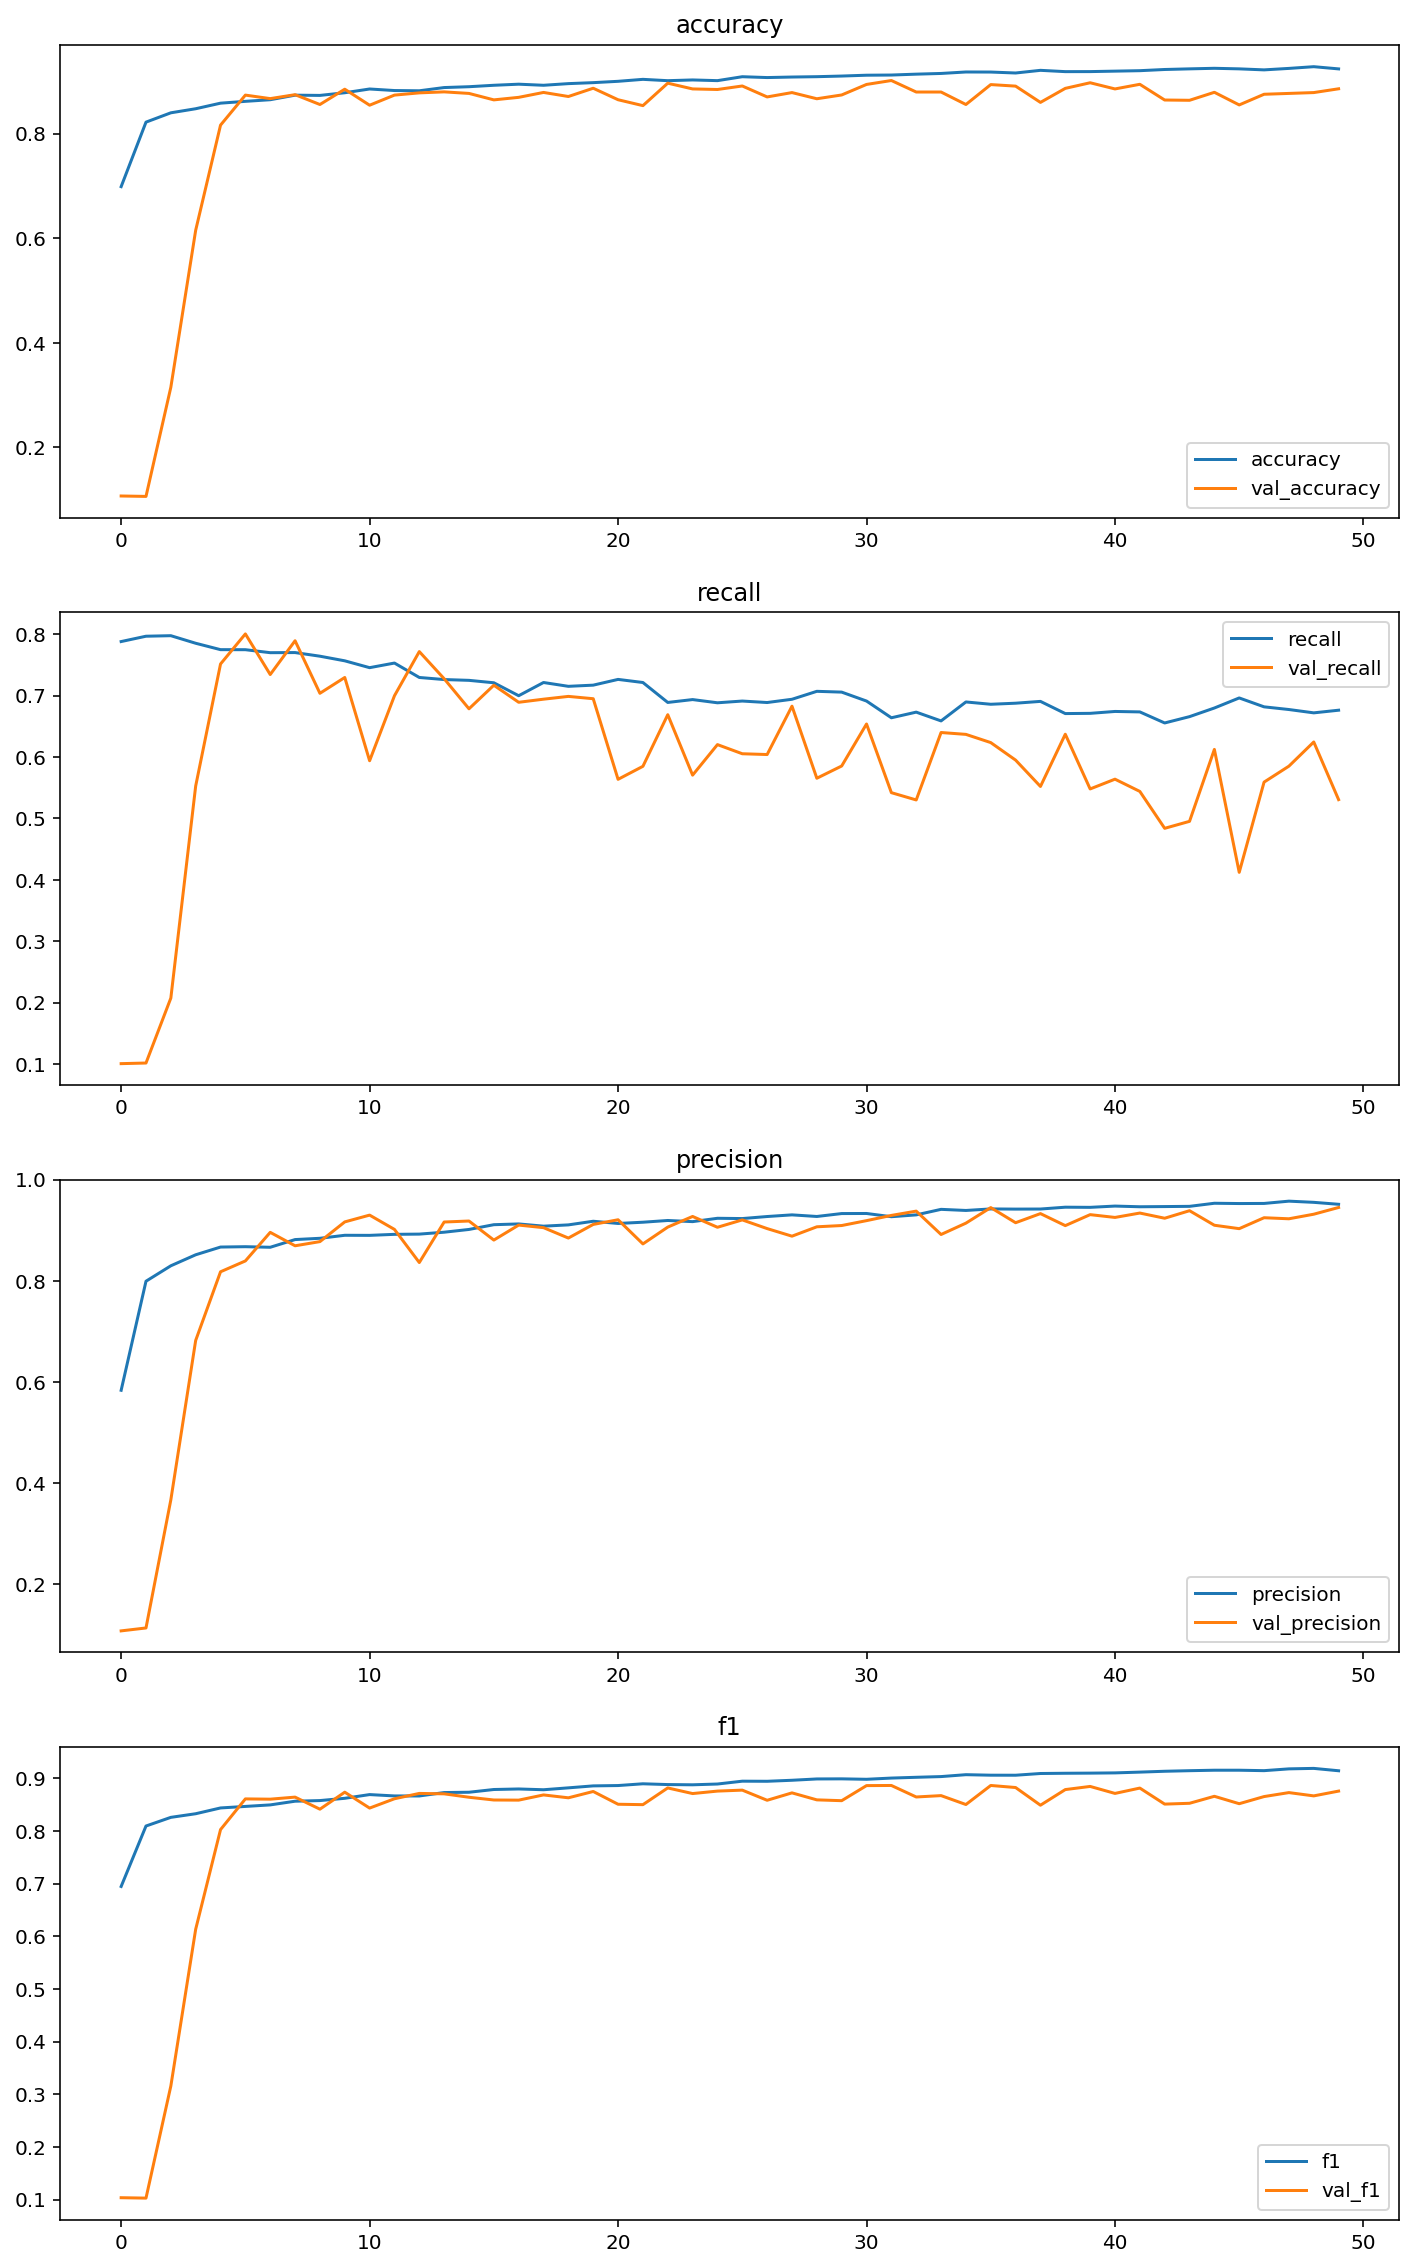

In [31]:
plot_curves(history)

In [48]:
pd.DataFrame(history.history).to_csv("/app/sandbox/history.csv")

In [21]:
prediction = model.predict(test)

In [22]:
test_sub = pd.DataFrame(prediction, columns=feature_columns)
for name in test_sub.columns.tolist():
    test_sub[name] = test_sub[name].replace({True: name, False: ""})
test_sub["all"] = test_sub.apply(" ".join, axis=1).str.split().str.join(sep=" ")

In [23]:
test_sub

,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab,all
0,complex,,,,,,complex
1,complex,frog_eye_leaf_spot,,,,,complex frog_eye_leaf_spot
2,,frog_eye_leaf_spot,,,,,frog_eye_leaf_spot


In [44]:
model.evaluate(valid)

59/59 [==============================] - 8s 133ms/step - loss: 0.6931 - categorical_accuracy: 0.8859 - recall_1: 0.5307 - precision_1: 0.9451 - f1_score: 0.8758


[0.6931450366973877,
 0.8859366774559021,
 0.5306740999221802,
 0.9451438784599304,
 0.8757642507553101]

In [28]:
a = model.predict(valid)

In [46]:
# np.argmax(a[0])
a[3].argsort()
valid._targets[3]

array([2, 3, 4, 5, 0, 1])

array([0, 0, 0, 0, 0, 1])

In [33]:
(a[555] > 0.5)
valid._targets[555]

array([False, False, False,  True, False, False])

array([0, 0, 0, 0, 1, 0])

In [26]:
d = [0, 0]
for i in np.linspace(0.01, 0.5, 100):
    b = sklearn.metrics.precision_recall_fscore_support(
        valid._targets, a > i, average="macro"
    )[2]
    if b > d[0]:
        d[0] = b
        d[1] = i

NameError: name 'a' is not defined

In [216]:
sklearn.metrics.precision_recall_fscore_support(
    valid._targets, a > 0.5, average="macro"
)[2]

0.12258990140768992

In [209]:
pd.DataFrame(history_100.history).to_csv("history_100.csv")

In [70]:
def f1(recall, precision):
    return 2 * ((precision * recall) / (precision + recall))

In [24]:
pd.DataFrame(history.history).tail(1)
pd.DataFrame(history.history).columns

,loss,categorical_accuracy,recall,precision,f1_score,val_loss,val_categorical_accuracy,val_recall,val_precision,val_f1_score
49,0.280581,0.922514,0.710095,0.954519,0.917384,0.539626,0.894257,0.628882,0.919528,0.889814


Index(['loss', 'categorical_accuracy', 'recall', 'precision', 'f1_score',
       'val_loss', 'val_categorical_accuracy', 'val_recall', 'val_precision',
       'val_f1_score'],
      dtype='object')

In [25]:
model.save("/app/_data/models/base_model", save_format="h5")